# Astronomical Aperture Photometry

Estimation of the depth of an SDSS image to get a sense for the uncertainties associated with the photometry that the SDSS database provides.

In [1]:
# Libraries Import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import astroquery
from astroquery.skyview import SkyView
from astropy import coordinates as coords
from astropy import units as u

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt

### Part 1

#### Image Download

In [2]:
# Convertion of the pixel scale into arcmin
scale=0.3/60 

# Calculating the number of pixels of the image with the size (rectangle of 30arcmin) and the scale
npixels=(30*u.arcmin)/(scale*u.arcmin)
npixels

<Quantity 6000.>

In [3]:
# Finding the position in degrees
position = coords.SkyCoord('0h8m05.63s +14d50m23.3s', frame='icrs')

# Obtaining the url of the image with the respective size and pixel number
imageid = SkyView.get_image_list(position, ['SDSSdr7r'], width=30*u.arcmin, height=30*u.arcmin, pixels=6000)
for address in imageid:
    print(address)

https://skyview.gsfc.nasa.gov/tempspace/fits/skv18058181203603.fits


In [5]:
# Download and reading the image data
image = fits.open('SDSSdr7r.fits')
data = image[0].data

#### Image Plot

In [6]:
# Compute the background statistics with the method of sigma-clipping
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(data, sigma=3.0)

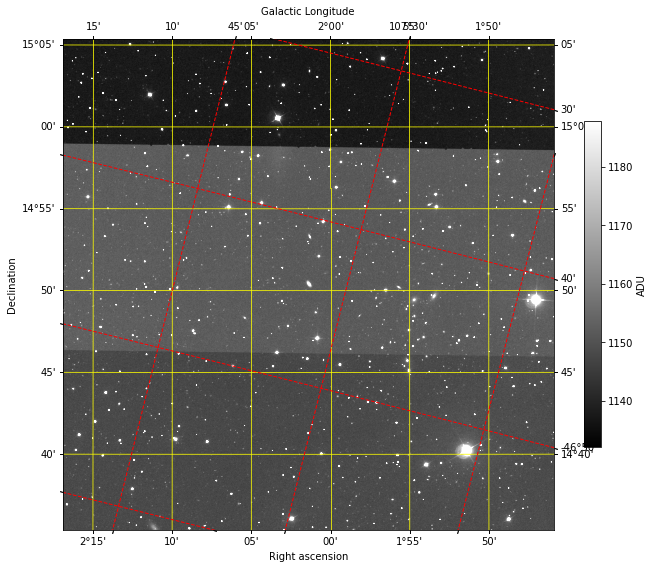

In [7]:
from astropy.wcs import WCS
wcs = WCS(image[0].header)

# Define the figure and the projection
fig = plt.figure(figsize=(11,10))
ax = plt.subplot(projection=wcs,)

# Display image
im = ax.imshow(data, cmap='gray', origin='lower', 
               vmin=bkg_median-2*bkg_sigma, 
               vmax=bkg_median+5*bkg_sigma )

# Setup axes
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_axislabel('Right ascension')
lat.set_axislabel('Declination')

lon.set_ticks(spacing=5.* u.arcmin)
lat.set_ticks(spacing=5.* u.arcmin)
lon.set_ticklabel_position('bt')
lat.set_ticklabel_position('lr')
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')

ax.grid(color='yellow', linestyle='solid', alpha=0.95)

# Add another grid, here the Galactic frame
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='red', ls='--', lw=1)
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel(' ')


# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU')

### Part 3

#### Aperture Photometry

In this method, the flux of all pixels around the source is added. The (usually circular) region where the pixels are added is called the aperture.

But in each pixel, the flux of the source is added to other signals (residues of bias or dark, and especially the sky). The total level can be estimated globally in the image, but it can vary in an image, especially if the field is large. So it is better to estimate the level locally, for each source. This is achieved by calculating the total flux of a ring centered on each source with a determined aperture radius and to estimate the contribution of the background, an annulus is taken to calculate the flux in it (this surrounds the source, so both radius are bigger than the aperture).

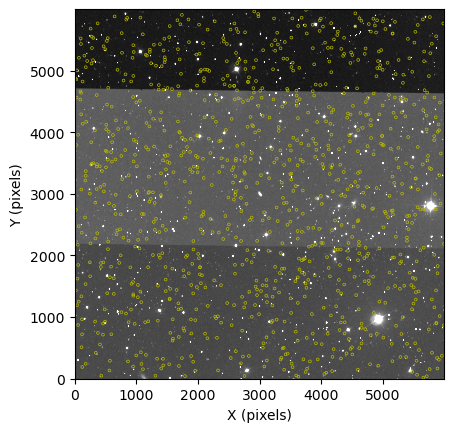

In [25]:
from photutils.aperture import CircularAperture, CircularAnnulus

# Defining Circular Radius dividing the aperture radius in arcsecs by the pixel scale
pixelscale = 0.3 
aperture_radius = 3 / pixelscale / 2

# Defining the limit centers of the positions of the point we are going to choose
min_center = int(np.ceil(aperture_radius))
max_center = int(np.floor(data.shape[0]-aperture_radius))

# Defining the 1000 apertures with the center positions randomly
N_apertures = 1000
np.random.seed(500)
x_centers = np.random.randint(min_center, max_center, size=N_apertures)
y_centers = np.random.randint(min_center, max_center, size=N_apertures)

for i in range(1000):
    if 2700<x_centers[i]<3300 and 2700<y_centers[i]<3300:
        np.delete(x_centers,i, axis=None)
        np.delete(y_centers,i, axis=None)

# Annulus Apertures
random_annulus = CircularAnnulus(zip(x_centers, y_centers), r_in=aperture_radius*1.2, r_out=aperture_radius*2.)

# Circular Apertures
circular_random_apertures = CircularAperture(zip(x_centers, y_centers), r=aperture_radius)

# Plot of the image and the 1000 selected apertures
with plt.style.context("default"):
    plt.imshow(data, cmap='gray', origin='lower',vmin=bkg_median-2*bkg_sigma, 
               vmax=bkg_median+5*bkg_sigma)
    circular_random_apertures.plot(color='y', lw=2)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')

In [26]:
from photutils.aperture import aperture_photometry
phot = aperture_photometry(data, circular_random_apertures)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,956.0,5304.0,89381.9524368523
2,3910.0,4776.0,89365.5106469073
3,278.0,5368.0,89380.96977379142
4,3795.0,3791.0,90409.00114153307
5,3010.0,4674.0,89668.35645124245
6,4388.0,2962.0,90452.4010124784
...,...,...,...
995,5474.0,1127.0,90344.04990219153


In [31]:
from photutils.aperture import ApertureStats
from astropy.stats import SigmaClip

sigclip = SigmaClip(sigma=3.0, maxiters=10)
aper_stats = ApertureStats(data, circular_random_apertures, sigma_clip=None)
bkg_stats = ApertureStats(data, random_annulus, sigma_clip=sigclip)
aper_bkg = bkg_stats.median
aper_sum_bkgsub = aper_stats.sum - aper_bkg

phot_table = aperture_photometry(data, circular_random_apertures)
phot_table['annulus_median'] = bkg_stats.mean
phot_table['aper_bkg'] = aper_bkg
phot_table['aper_sum_bkgsub'] = aper_sum_bkgsub

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g' 
print(phot_table)

 id  xcenter ycenter aperture_sum annulus_median aper_bkg aper_sum_bkgsub
       pix     pix                                                       
---- ------- ------- ------------ -------------- -------- ---------------
   1     956    5304    89381.952      1140.0255     1139       88242.952
   2    3910    4776    89365.511      1139.2041     1139       88226.511
   3     278    5368     89380.97      1138.0777     1138        88242.97
   4    3795    3791    90409.001      1151.7938     1152       89257.001
   5    3010    4674    89668.356      1145.1633     1144       88524.356
   6    4388    2962    90452.401      1151.7449     1152       89300.401
 ...     ...     ...          ...            ...      ...             ...
 994    2959    1447     90103.48      1148.4462     1148        88955.48
 995    5474    1127     90344.05      1150.7526     1151        89193.05
 996    4613    2223     90466.89      1152.3061     1152        89314.89
 997     267    3477    91528.913     

In [38]:
from photutils.aperture import ApertureStats
from astropy.stats import SigmaClip

aperstats = ApertureStats(data, random_annulus)
bkg_mean = aperstats.mean
aperture_area = circular_random_apertures.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

phot_table = aperture_photometry(data, circular_random_apertures)
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id  xcenter ycenter aperture_sum total_bkg aperture_sum_bkgsub
       pix     pix                                             
---- ------- ------- ------------ --------- -------------------
   1     956    5304    89381.952 89537.394          -155.44176
   2    3910    4776    89365.511 89472.879           -107.3687
   3     278    5368     89380.97 89363.485           17.485173
   4    3795    3791    90409.001 90476.266          -67.264428
   5    3010    4674    89668.356 89940.913          -272.55608
   6    4388    2962    90452.401 90457.833          -5.4317435
 ...     ...     ...          ...       ...                 ...
 994    2959    1447     90103.48 90191.759          -88.278954
 995    5474    1127     90344.05 90415.357          -71.307239
 996    4613    2223     90466.89 90501.911          -35.020995
 997     267    3477    91528.913 99495.522          -7966.6087
 998    2814    4519    90600.654 90509.925           90.728947
 999    2092    3259    90463.982 90538.

In [39]:
fluxes = phot_table['aperture_sum_bkgsub'].data

Text(0, 0.5, 'Number of Apertures')

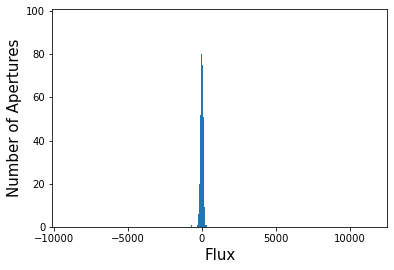

In [40]:
plt.hist(fluxes,1000)
plt.xlabel("Flux", size=15)
plt.ylabel("Number of Apertures", size=15)


In [41]:
fluxes_std = fluxes.std(ddof=1)
print('The std of the fluxes: {:.3f}'.format(fluxes_std))

The std of the fluxes: 571.364


In [42]:
fivesigmalimitflux = 5*fluxes_std
print('The corresponding 5 sigma limiting flux is: {:.2f}'.format(fivesigmalimitflux))

The corresponding 5 sigma limiting flux is: 2856.82


### Part 3

#### Signal to Noise Ratio

$ S/N = \frac{ f_\star }{ \sqrt{\sum \sigma_i^2 }} $, 
with $f_\star$ the source flux, and $\sigma_i$ the noises of the sources and the sky background.

In [47]:
phot_table['noise'] = np.sqrt( phot_table['aperture_sum_bkgsub'] +  # photon noise: source
                               phot_table['total_bkg'] )         # photon noise: sky
phot_table['S/N'] = phot_table['aperture_sum_bkgsub'] / phot_table['noise']

print(phot_table)

 id  xcenter ycenter aperture_sum ... aperture_sum_bkgsub   noise       S/N     
       pix     pix                ...                                           
---- ------- ------- ------------ ... ------------------- --------- ------------
   1     956    5304    89381.952 ...          -155.44176 298.96815  -0.51992749
   2    3910    4776    89365.511 ...           -107.3687 298.94065  -0.35916393
   3     278    5368     89380.97 ...           17.485173  298.9665  0.058485392
   4    3795    3791    90409.001 ...          -67.264428  300.6809  -0.22370702
   5    3010    4674    89668.356 ...          -272.55608 299.44675  -0.91019884
   6    4388    2962    90452.401 ...          -5.4317435 300.75306 -0.018060476
 ...     ...     ...          ... ...                 ...       ...          ...
 994    2959    1447     90103.48 ...          -88.278954 300.17242  -0.29409416
 995    5474    1127     90344.05 ...          -71.307239 300.57287  -0.23723778
 996    4613    2223     904